In [1]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

import torch
from mlp_train import Net, train, evaluate, detect_digit

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
### Testing ############################
model = Net()
model.load_state_dict(torch.load('model_weights.pt'))
#print(model)
evaluate(model)

Test Loss: 0.060991

Test Accuracy of     0: 99% (973/980)
Test Accuracy of     1: 99% (1128/1135)
Test Accuracy of     2: 97% (1011/1032)
Test Accuracy of     3: 97% (987/1010)
Test Accuracy of     4: 98% (967/982)
Test Accuracy of     5: 97% (874/892)
Test Accuracy of     6: 98% (948/958)
Test Accuracy of     7: 97% (1006/1028)
Test Accuracy of     8: 96% (943/974)
Test Accuracy of     9: 96% (975/1009)

Test Accuracy (Overall): 98% (9812/10000)


C:\PyData\anaconda3\envs\image\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


  0%|          | 0/9912422 [00:00<?, ?it/s]

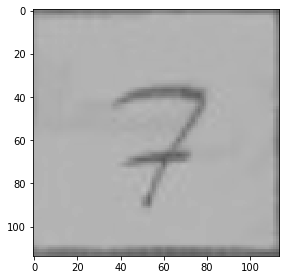

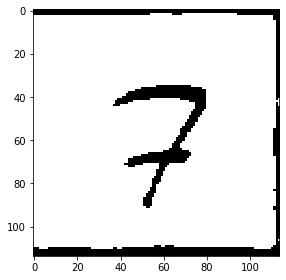

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



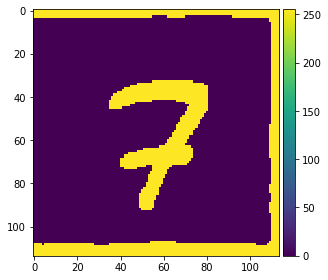

Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



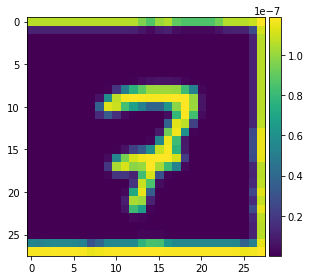

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw

Test Loss: 0.061771

Test Accuracy of     0: 99% (972/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 97% (1007/1032)
Test Accuracy of     3: 97% (988/1010)
Test Accuracy of     4: 98% (971/982)
Test Accuracy of     5: 98% (875/892)
Test Accuracy of     6: 99% (951/958)
Test Accuracy of     7: 97% (1005/1028)
Test Accuracy of     8: 97% (946/974)
Test Accuracy of     9: 96% (973/1009)

Test Accuracy (Overall): 98% (9813/10000)


In [3]:
### Testing ############################
model = Net()
model.load_state_dict(torch.load('model_weights.pt'))
#print(model)
evaluate(model)

In [ ]:
### Testing ############################

from skimage.morphology import binary_dilation
from skimage.transform import resize

plt.figure()
plt.imshow(io.imread('aa.jpeg'))

im = io.imread('aa.jpeg',as_gray=True)

im = resize(im, (114,114))
plt.figure()
io.imshow(im)

im = im>0.6
plt.figure()
io.imshow(im)

im = np.invert(im)
im = binary_dilation(im, [[1,1,1,1],[1,1,1,1],[1,1,1,1],[1,1,1,1]])

im = im*255
plt.figure()
io.imshow(im)

im = resize(im, (28,28))
plt.figure()
io.imshow(im);

In [ ]:
## Use Case #######################

p = detect_digit(io.imread('seven.jpeg',as_gray=True), plot=True)
print('Pridection: ', p)